In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
import umap
import os
import seaborn as sns
from data_loader import load_data_recursively
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def get_client_type(label_str):
    """extracts environment type from label like 'Client_1_Moon' -> 'Moon'"""
    try:
        return label_str.split('_', 2)[2]
    except (IndexError, TypeError):
        return label_str



# Plot Learning Curves



In [61]:
se_path = 'sv_results/v5/all_metrics.csv'

df = pd.read_csv(se_path)


df = df[df['run_type'] != 'single_moon']


print(df['run_type'].unique())

df['run_type'] = df['run_type'].replace({'dp_fl_sens18.0_eps100.0': 'DP-FedRL Eps=100', 
'dp_fl_sens18.0_eps500.0': 'DP-FedRL Eps=500', 'dp_fl_sens18.0_eps5000' : 'DP-FedRL Eps=5000', 'dp_fl_sens18.0_eps1000.0': 'DP-FedRL Eps=1000',
'fl_run': 'Baseline FL'
})
df['episode_id'] = df.groupby('metric').cumcount()

df_pivoted = df.pivot(
    index=['round','step', 'run_type', 'client_id', 'episode_id'], 
    columns='metric', 
    values='value'
).reset_index()

df_pivoted.columns.name = None
df_pivoted.head()


df_pivoted.to_csv('sv_results/v5/all_metrics_pivoted.csv', index=False)

['dp_fl_sens18.0_eps100.0' 'dp_fl_sens18.0_eps500.0'
 'dp_fl_sens18.0_eps5000' 'dp_fl_sens18.0_eps1000.0' 'fl_run']


### ROUND

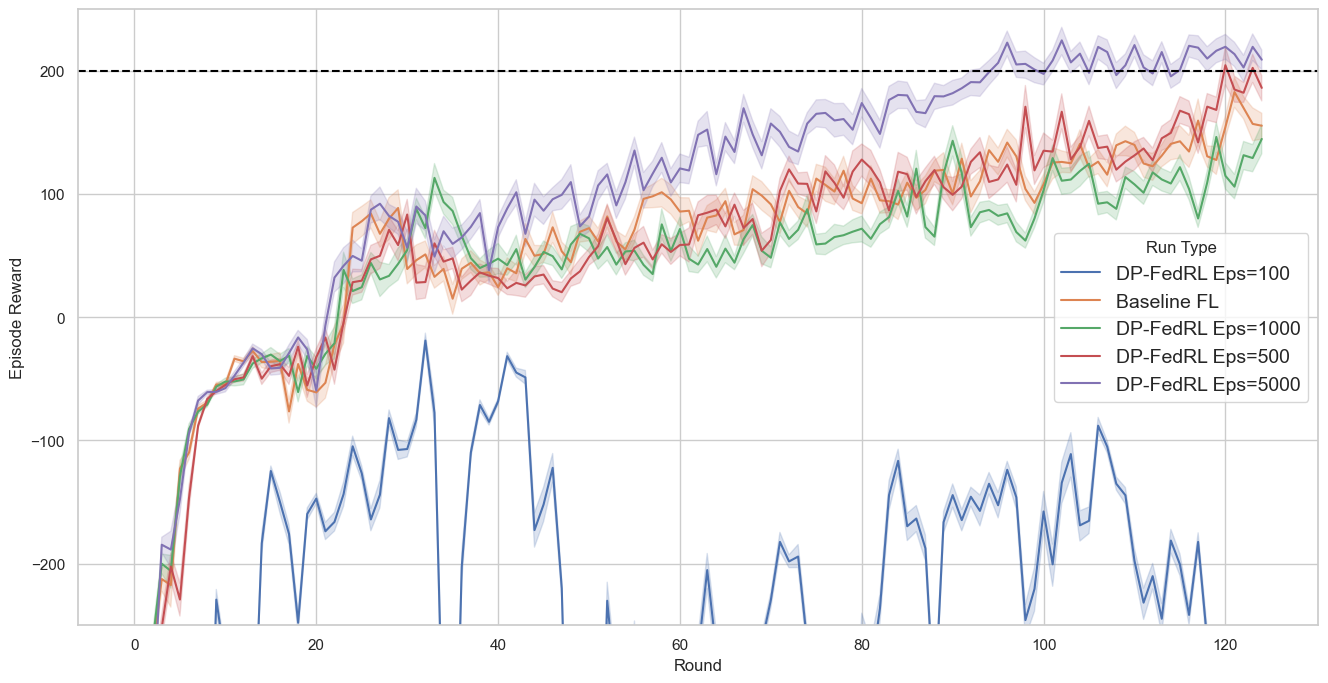

In [56]:


OUTPUT_DIR = "figures"
# Ensure the directory exists BEFORE trying to save
os.makedirs(OUTPUT_DIR, exist_ok=True) 

plt.figure(figsize=(16, 8))
sns.lineplot(data=df_pivoted, x="round", y="episode_reward", hue="run_type")

plt.xlabel("Round")
plt.ylabel("Episode Reward")
plt.ylim(-250, 250)
plt.axhline(y=200, color="black", linestyle="--")
plt.legend(title="Run Type",markerscale=2, fontsize=14)

# --- FIX START ---
# 1. Define the path
filename = "round_learning_curve.pdf"
out_path = os.path.join(OUTPUT_DIR, filename)

# 2. Save the figure FIRST (while the canvas still has data)
plt.savefig(out_path, dpi=150, bbox_inches='tight') 

# 3. Show the figure LAST (this will clear the canvas)
plt.show()



### Step

In [62]:
df_pivoted.loc[df_pivoted['client_id'].str.contains('Earth', case=False, na=False), 'Category'] = 'Earth'
df_pivoted.loc[df_pivoted['client_id'].str.contains('Mars', case=False, na=False), 'Category'] = 'Mars'
df_pivoted.loc[df_pivoted['client_id'].str.contains('Moon', case=False, na=False), 'Category'] = 'Moon'
df_pivoted.head()

,round,step,run_type,client_id,episode_id,episode_length,episode_reward,Category
0,0,55,DP-FedRL Eps=100,Client_-2_Earth,0,55.00,-132.97,Earth
1,0,56,DP-FedRL Eps=100,Client_-4_Earth,69467,56.00,-325.22,Earth
2,0,59,Baseline FL,Client_-4_Earth,516926,59.00,-273.60,Earth
3,0,60,Baseline FL,Client_-3_Earth,496653,60.00,-91.36,Earth
4,0,60,DP-FedRL Eps=1000,Client_2_Earth,463037,60.00,-91.64,Earth


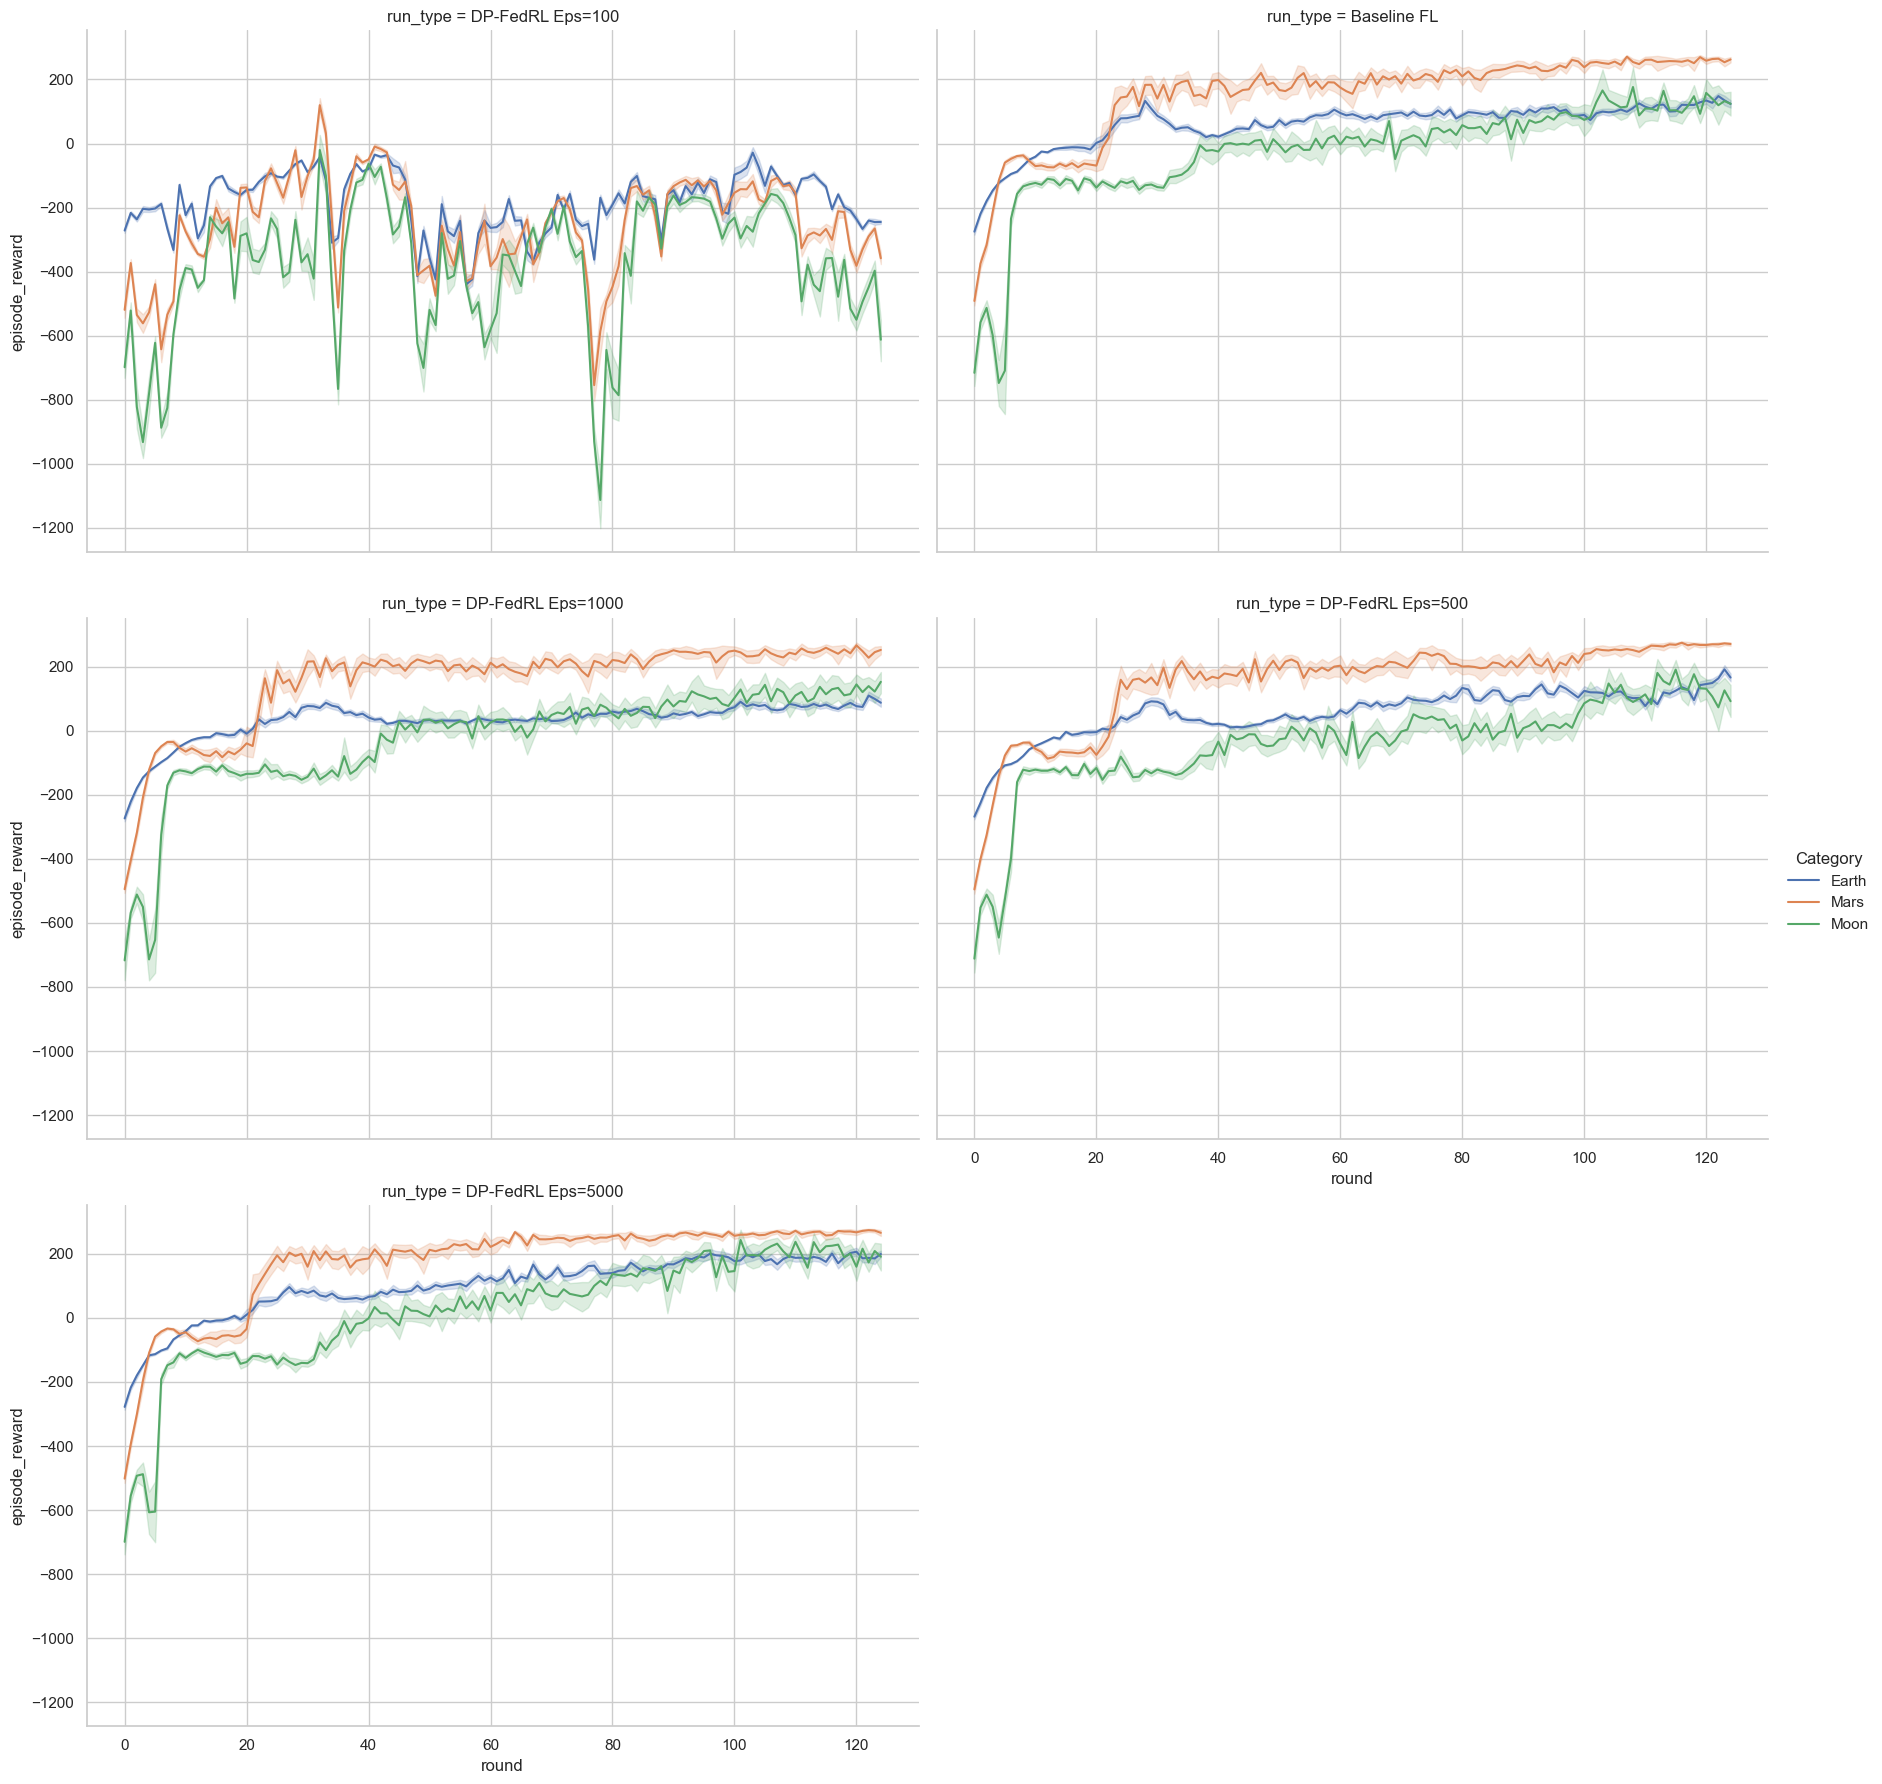

In [71]:
sns.relplot(
    data=df_pivoted,
    kind="line",
    x="round",
    y="episode_reward",
    hue="Category",
    col="run_type",
    col_wrap=2,  
    height=6,
    aspect=1.5       # Controls the aspect ratio (width/height)
)

# EVALUATION RESULTS

In [42]:
import gymnasium as gym
from stable_baselines3 import PPO
import os
import numpy as np
import pandas as pd

# --- CONFIGURATION ---

# 1. MODELS: Dictionary of { "Name": "Path" }
MODELS = {
    "Single Moon": "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v5/logs/single_moon/single_Client_1_Moon_model_final.zip",
    "Single Earth": "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v5/logs/single_moon/single_Client_2_Earth_model_final.zip",
    "Single Mars": "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v5/logs/single_moon/single_Client_3_Mars_model_final.zip",
    "Baseline FL": "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v5/logs/fl_run/global_fl_model_final.zip",
    "Model EPS=100": "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v5/logs/dp_fl_sens18.0_eps100.0/global_model_final.zip",
    "Model EPS=500": "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v5/logs/dp_fl_sens18.0_eps500.0/global_model_final.zip",
    "Model EPS=1000": "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v5/logs/dp_fl_sens18.0_eps1000.0/global_model_final.zip",
    "Model EPS=5000": "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v5/logs/dp_fl_sens18.0_eps5000/global_model_final.zip",
}

# 2. ALGORITHM
AlgorithmClass = PPO 

# 3. SETTINGS
N_EVAL_EPISODES = 200

# 4. SCENARIOS
SCENARIOS = [
    {"name": "Earth - No Wind",  "gravity": -9.8, "enable_wind": False, "wind_power": 0.0},
    {"name": "Mars - Wind=5",    "gravity": -3.73,  "enable_wind": True, "wind_power": 5.0},
    {"name": "Moon - Wind=15",   "gravity": -1.62, "enable_wind": True,  "wind_power": 15.0},
    {"name": "Earth - Wind=6",   "gravity": -9.8, "enable_wind": True, "wind_power": 6.0},
    {"name": "Mars - Wind=8",    "gravity": -3.73,  "enable_wind": True, "wind_power": 8.0},
    {"name": "Moon - Wind=7",    "gravity": -1.62, "enable_wind": True,  "wind_power": 7.0},
    {"name": "Turbulence",       "gravity": -10.0, "enable_wind": True,  "wind_power": 10.0, "turbulence_power": 1.5},
]

# ---------------------

# List for the Summary Table (Mean/Std)
summary_data = []
# List for the Detailed Episode Data (Row per episode)
raw_episode_data = []

print(f"Starting evaluation of {len(MODELS)} models across {len(SCENARIOS)} scenarios...")
print("-" * 60)

for model_name, model_path in MODELS.items():
    
    # 1. Check file existence
    if not os.path.exists(model_path):
        print(f"!! WARNING: Skipping '{model_name}'. File not found: {model_path}")
        continue
        
    try:
        print(f">> Loading {model_name}...")
        model = AlgorithmClass.load(model_path)
        
        # 2. Iterate through Scenarios
        for scenario_config in SCENARIOS:
            config = scenario_config.copy()
            scenario_name = config.pop("name")
            
            # Create environment
            env = gym.make("LunarLander-v3", render_mode=None, **config)
            
            current_scenario_rewards = []
            
            # 3. Run Episodes
            for i in range(N_EVAL_EPISODES):
                obs, _ = env.reset()
                done = False
                truncated = False
                total_reward = 0
                
                while not (done or truncated):
                    action, _ = model.predict(obs, deterministic=True)
                    obs, reward, done, truncated, _ = env.step(action)
                    total_reward += reward
                
                current_scenario_rewards.append(total_reward)

                # --- NEW: Save raw episode data ---
                raw_episode_data.append({
                    "Model": model_name,
                    "Scenario": scenario_name,
                    "Episode Number": i + 1,
                    "Reward": total_reward
                })
            
            # 4. Aggregate Stats for Summary
            mean_reward = np.mean(current_scenario_rewards)
            std_reward = np.std(current_scenario_rewards)
            
            summary_data.append({
                "Model": model_name,
                "Scenario": scenario_name,
                "Mean Reward": mean_reward,
                "Std Dev": std_reward
            })
            
            env.close()
            
    except Exception as e:
        print(f"!! Error evaluating {model_name}: {e}")

# --- DISPLAY AND SAVE ---

if summary_data:
    # 1. Process Summary Data
    summary_df = pd.DataFrame(summary_data)

    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.float_format', '{:.2f}'.format)

    print("\n" + "="*30)
    print("      FINAL COMPARISON")
    print("="*30)

    # Pivot Table
    pivot_df = summary_df.pivot(index="Scenario", columns="Model", values="Mean Reward")
    
    print("\n--- Average Reward by Model & Scenario ---")
    print(pivot_df)
    
    # Save Pivot Summary
    pivot_df.to_csv("/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/figures/summary_pivot_results.csv")
    
    # 2. Process Raw Episode Data
    raw_df = pd.DataFrame(raw_episode_data)
    
    # Reorder columns to match your requested format logic (Model included for clarity)
    raw_df = raw_df[["Model", "Scenario", "Episode Number", "Reward"]]
    
    # Save Raw Data
    raw_csv_path = "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/figures/raw_episode_results.csv"
    raw_df.to_csv(raw_csv_path, index=False)
    
    print(f"\n>> Detailed episode results saved to: {raw_csv_path}")
    print(raw_df.head()) # Print first few rows to verify

else:
    print("\nNo results generated. Check your model paths.")

Starting evaluation of 8 models across 7 scenarios...
------------------------------------------------------------
>> Loading Single Moon...
>> Loading Single Earth...
>> Loading Single Mars...
>> Loading Baseline FL...
>> Loading Model EPS=100...
>> Loading Model EPS=500...
>> Loading Model EPS=1000...
>> Loading Model EPS=5000...

      FINAL COMPARISON

--- Average Reward by Model & Scenario ---
Model            Baseline FL  Model EPS=100  Model EPS=1000  Model EPS=500  Model EPS=5000  Single Earth  Single Mars  Single Moon
Scenario                                                                                                                          
Earth - No Wind       254.20        -378.96          231.65         256.18          273.94        241.32       191.10        32.66
Earth - Wind=6        199.76        -343.54          179.52         216.64          234.39        229.15       143.10        -9.90
Mars - Wind=5         248.33        -540.93          210.59         240.79

# Generate UMAP plot

## Classification

In [45]:
def plot_umap_weights(data, directory, output_filename="umap_weights.png", title="FRL"):
    print(f"\nGenerating UMAP plot and Metrics for {title}...")

    weights = data['weights']
    labels = data['weight_labels']
    steps = data['weight_steps']

    if len(weights) == 0:
        print("No data found to plot.")
        return

    # 1. Run UMAP Globally
    print("Running UMAP dimensionality reduction...")
    reducer = umap.UMAP(n_components=2, verbose=False, random_state=42)
    umap_results = reducer.fit_transform(weights)

    # --- NEW: QUANTITATIVE METRICS ---
    # Convert filenames to Client Types (labels for our metrics)
    client_types = np.array([get_client_type(l) for l in labels])
    
    # A. Calculate Silhouette Score (Distance Separation)
    # We use umap_results to measure separation in the PLOT space. 
    # (You could also use 'weights' to measure separation in high-dim space)
    try:
        sil_score = silhouette_score(umap_results, client_types)
        print(f"[{title}] Silhouette Score: {sil_score:.4f} (Higher = More Separated)")
    except Exception as e:
        print(f"Could not calc silhouette: {e}")

    # B. Calculate Identifiability (Can we guess the client?)
    # Split data to train a simple classifier
    X_train, X_test, y_train, y_test = train_test_split(umap_results, client_types, test_size=0.3, random_state=42)
    
    clf = KNeighborsClassifier(n_neighbors=15)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"[{title}] Client Identification Accuracy: {acc:.2%} (Lower = Better Privacy)")
    # ---------------------------------

    # 2. Setup Markers (Existing plotting code continues below...)
    all_types = [get_client_type(l) for l in labels]
    unique_types = sorted(list(set(all_types)))
    
    markers_list = ['o', 's', '^', 'D', 'X', 'P', '*']
    type_to_marker = {t: markers_list[i % len(markers_list)] for i, t in enumerate(unique_types)}

    # 3. Plotting
    plt.figure(figsize=(8, 6))

    # Sort by time
    sort_idx = np.argsort(steps)
    umap_results_sorted = umap_results[sort_idx]
    labels_sorted = labels[sort_idx]
    steps_sorted = steps[sort_idx]
    sorted_types = [get_client_type(l) for l in labels_sorted]
    
    sc = None
    
    for t in unique_types:
        indices = [i for i, x in enumerate(sorted_types) if x == t]
        if not indices: continue
        
        type_umap = umap_results_sorted[indices]
        type_steps = steps_sorted[indices]
        marker = type_to_marker[t]

        sc = plt.scatter(
            type_umap[:, 0],
            type_umap[:, 1],
            c=type_steps,
            cmap='plasma',
            marker=marker,
            alpha=0.7,      
            s=80,
            edgecolors='k',
            linewidth=0.3,
            vmin=np.min(steps),
            vmax=np.max(steps),
            label=f"Type: {t}"
        )

    # Add the metrics to the plot title or caption for the "Proof"
    final_title = (f'{title}: UMAP Trajectory\n'
                 f'K-Means Identifiability: {acc:.0%}')
    plt.title(final_title)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')

    # Legend and Save
    handles = []
    legend_labels = []
    for t in unique_types:
        h = plt.Line2D([0], [0], marker=type_to_marker[t], color='w',
                       markerfacecolor='grey', markeredgecolor='black', 
                       markersize=10)
        handles.append(h)
        legend_labels.append(t)

    plt.legend(handles, legend_labels, title='Client Type', loc='upper left')

    if sc:
        cbar = plt.colorbar(sc)
        cbar.set_label('Round Number (Yellow = Newest)')

    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    os.makedirs(directory, exist_ok=True)
    out_path = os.path.join(directory, output_filename)
    plt.savefig(out_path, dpi=150)
    print(f"Saved '{out_path}'")

--- Processing Standard FL (No DP) ---
Scanning sv_results/v5/logs/fl_run/weights...
Loaded 1375 weight vectors.

Generating UMAP plot and Metrics for Standard FL...
Running UMAP dimensionality reduction...


/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/rlproject/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[Standard FL] Silhouette Score: -0.0098 (Higher = More Separated)
[Standard FL] Client Identification Accuracy: 35.59% (Lower = Better Privacy)
Saved 'figures/fl_trajectory.pdf'


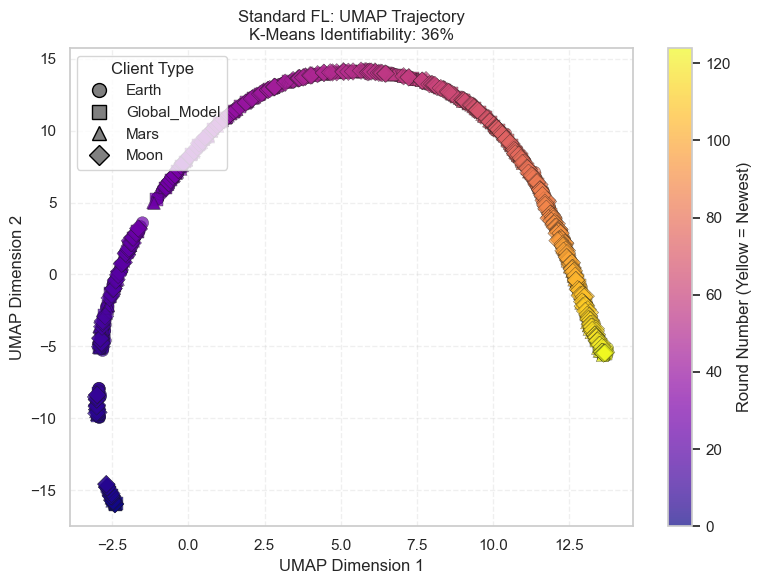

In [46]:
# --- MAIN EXECUTION ---
MAX_ROUNDS = None
FL_PATH = "sv_results/v5/logs/fl_run/weights"
OUTPUT_DIR = "figures"

# 1. Process Standard FL
print("--- Processing Standard FL (No DP) ---")
fl_data = load_data_recursively(FL_PATH, MAX_ROUNDS)
if len(fl_data['weights']) > 0:
    plot_umap_weights(fl_data, OUTPUT_DIR, output_filename="fl_trajectory.pdf", title="Standard FL")

# 2. Process DP FL




--- Processing DP 1000 FL ---
Scanning sv_results/v5/logs/dp_fl_sens18.0_eps1000.0/weights...
Loaded 1375 weight vectors.

Generating UMAP plot and Metrics for Differentially Private FL EPS=1000...
Running UMAP dimensionality reduction...


/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/rlproject/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[Differentially Private FL EPS=1000] Silhouette Score: -0.0127 (Higher = More Separated)
[Differentially Private FL EPS=1000] Client Identification Accuracy: 34.87% (Lower = Better Privacy)
Saved 'figures/dp_1000trajectory.pdf'


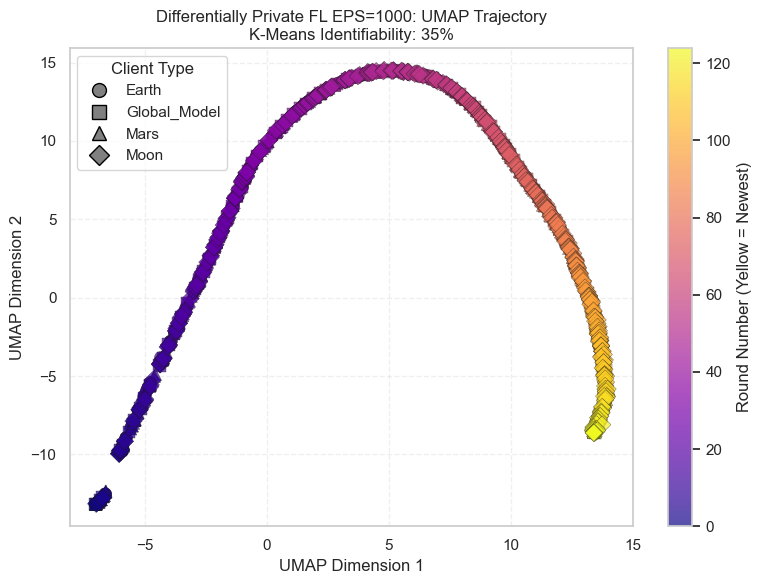

In [47]:
print("\n--- Processing DP 1000 FL ---")

DP1000_PATH = "sv_results/v5/logs/dp_fl_sens18.0_eps1000.0/weights"
dp_data = load_data_recursively(DP1000_PATH, MAX_ROUNDS)
if len(dp_data['weights']) > 0:
    plot_umap_weights(dp_data, OUTPUT_DIR, output_filename="dp_1000trajectory.pdf", title="Differentially Private FL EPS=1000")




--- Processing D 100 FL ---
Scanning sv_results/v5/logs/dp_fl_sens18.0_eps100.0/weights...
Loaded 1375 weight vectors.

Generating UMAP plot and Metrics for Differentially Private FL EPS=100...
Running UMAP dimensionality reduction...


/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/rlproject/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[Differentially Private FL EPS=100] Silhouette Score: -0.0108 (Higher = More Separated)
[Differentially Private FL EPS=100] Client Identification Accuracy: 28.09% (Lower = Better Privacy)
Saved 'figures/dp_100trajectory.pdf'


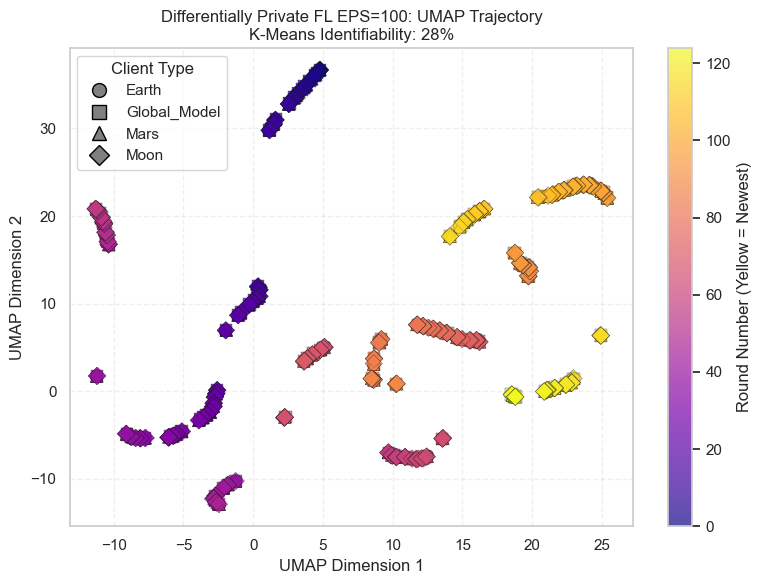

In [48]:
print("\n--- Processing D 100 FL ---")
DP100_PATH = "sv_results/v5/logs/dp_fl_sens18.0_eps100.0/weights"

dp_data = load_data_recursively(DP100_PATH, MAX_ROUNDS)
if len(dp_data['weights']) > 0:
    plot_umap_weights(dp_data, OUTPUT_DIR, output_filename="dp_100trajectory.pdf", title="Differentially Private FL EPS=100")




--- Processing D 500 FL ---
Scanning sv_results/v5/logs/dp_fl_sens18.0_eps500.0/weights...
Loaded 1375 weight vectors.

Generating UMAP plot and Metrics for Differentially Private FL EPS= 500...
Running UMAP dimensionality reduction...


/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/rlproject/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[Differentially Private FL EPS= 500] Silhouette Score: -0.0133 (Higher = More Separated)
[Differentially Private FL EPS= 500] Client Identification Accuracy: 31.96% (Lower = Better Privacy)
Saved 'figures/dp_500trajectory.pdf'


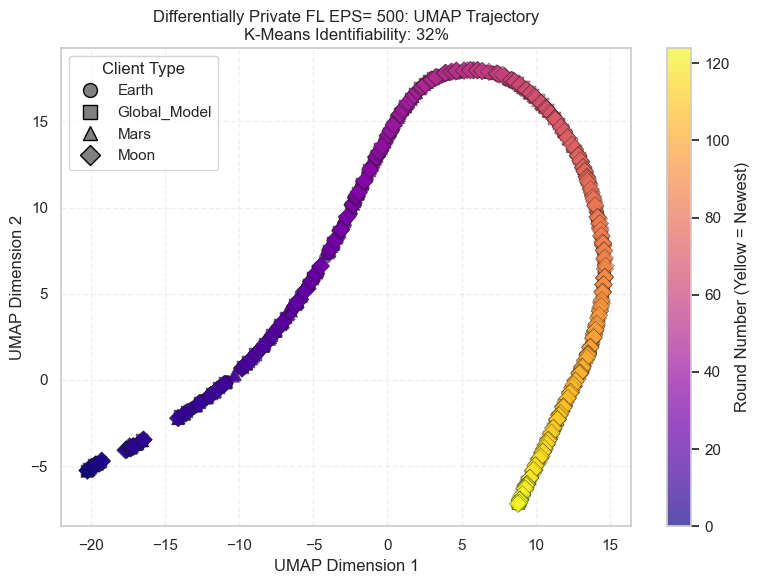

In [50]:
print("\n--- Processing D 500 FL ---")
DP500_PATH = "sv_results/v5/logs/dp_fl_sens18.0_eps500.0/weights"
dp_data = load_data_recursively(DP500_PATH, MAX_ROUNDS)
if len(dp_data['weights']) > 0:
    plot_umap_weights(dp_data, OUTPUT_DIR, output_filename="dp_500trajectory.pdf", title="Differentially Private FL EPS= 500")




--- Processing D 5000 FL ---
Scanning sv_results/v5/logs/dp_fl_sens18.0_eps5000/weights...
Loaded 1375 weight vectors.

Generating UMAP plot and Metrics for Differentially Private FL EPS=5000...
Running UMAP dimensionality reduction...


/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/rlproject/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[Differentially Private FL EPS=5000] Silhouette Score: -0.0123 (Higher = More Separated)
[Differentially Private FL EPS=5000] Client Identification Accuracy: 33.17% (Lower = Better Privacy)
Saved 'figures/dp_5000trajectory.pdf'


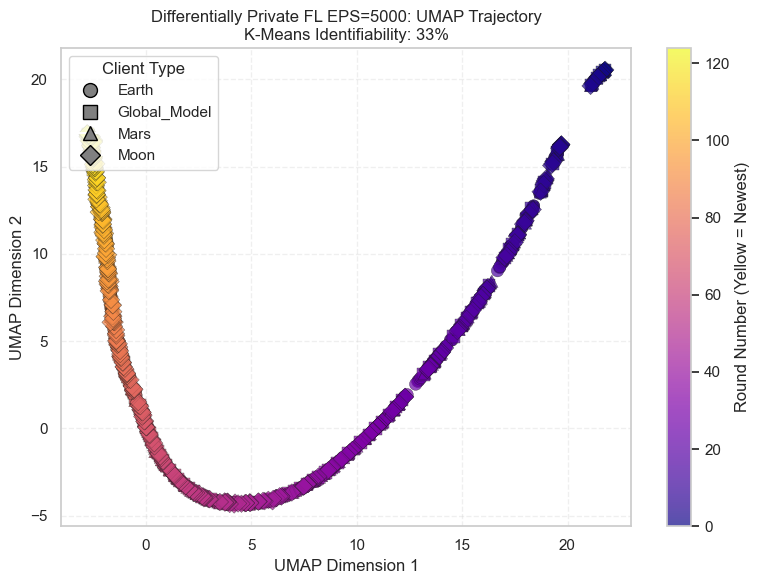

In [51]:
print("\n--- Processing D 5000 FL ---")
DP5000_PATH = "sv_results/v5/logs/dp_fl_sens18.0_eps5000/weights"
dp_data = load_data_recursively(DP5000_PATH, MAX_ROUNDS)
if len(dp_data['weights']) > 0:
    plot_umap_weights(dp_data, OUTPUT_DIR, output_filename="dp_5000trajectory.pdf", title="Differentially Private FL EPS=5000")

# Generate gif of agent

In [ ]:
import imageio
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Define your environment arguments here
env_kwargs = {
    "enable_wind": True,
    "wind_power": 6.0,       # Recommended between 0.0 and 20.0
    "enable_wind": True,
    "gravity": -9.8
}

# Pass the dictionary to make_vec_env
env = make_vec_env("LunarLander-v3", n_envs=1, env_kwargs=env_kwargs)

model = PPO.load("/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/fl_run/global_fl_model_final.zip", env=env)

images = []
obs = env.reset()
img = env.render(mode="rgb_array")

for i in range(2000):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _, _ = env.step(action)
    img = env.render(mode="rgb_array")

imageio.mimsave("lander_windy.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

# Plot evaluation results

/var/folders/71/_krxyrzs7sb77_634p5ptbmm0000gn/T/ipykernel_54185/2499994763.py:43: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


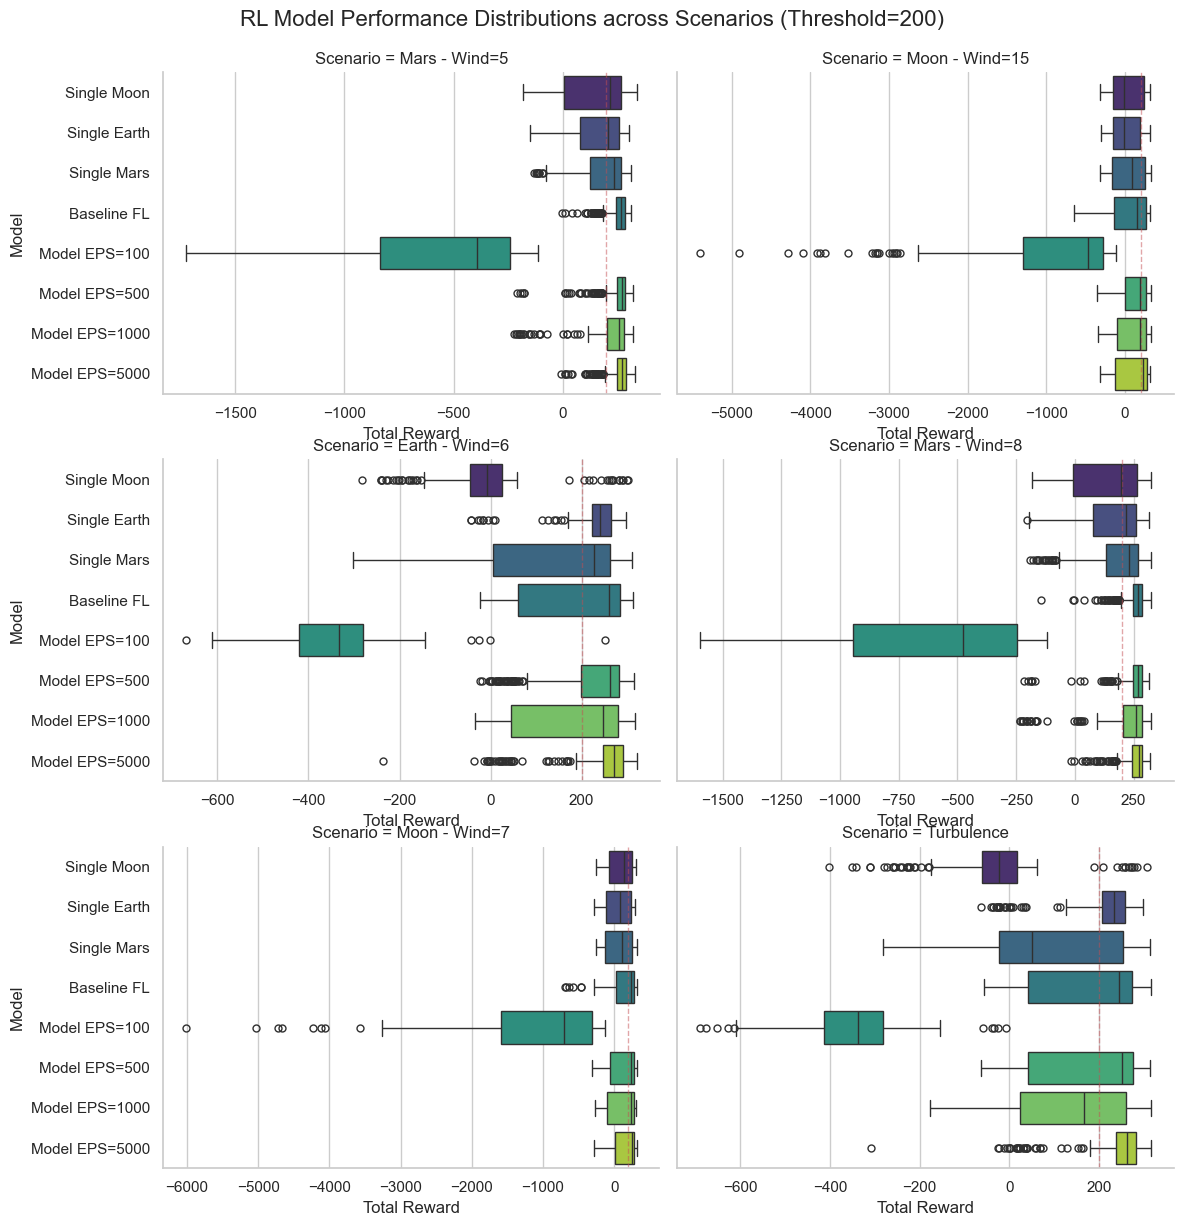

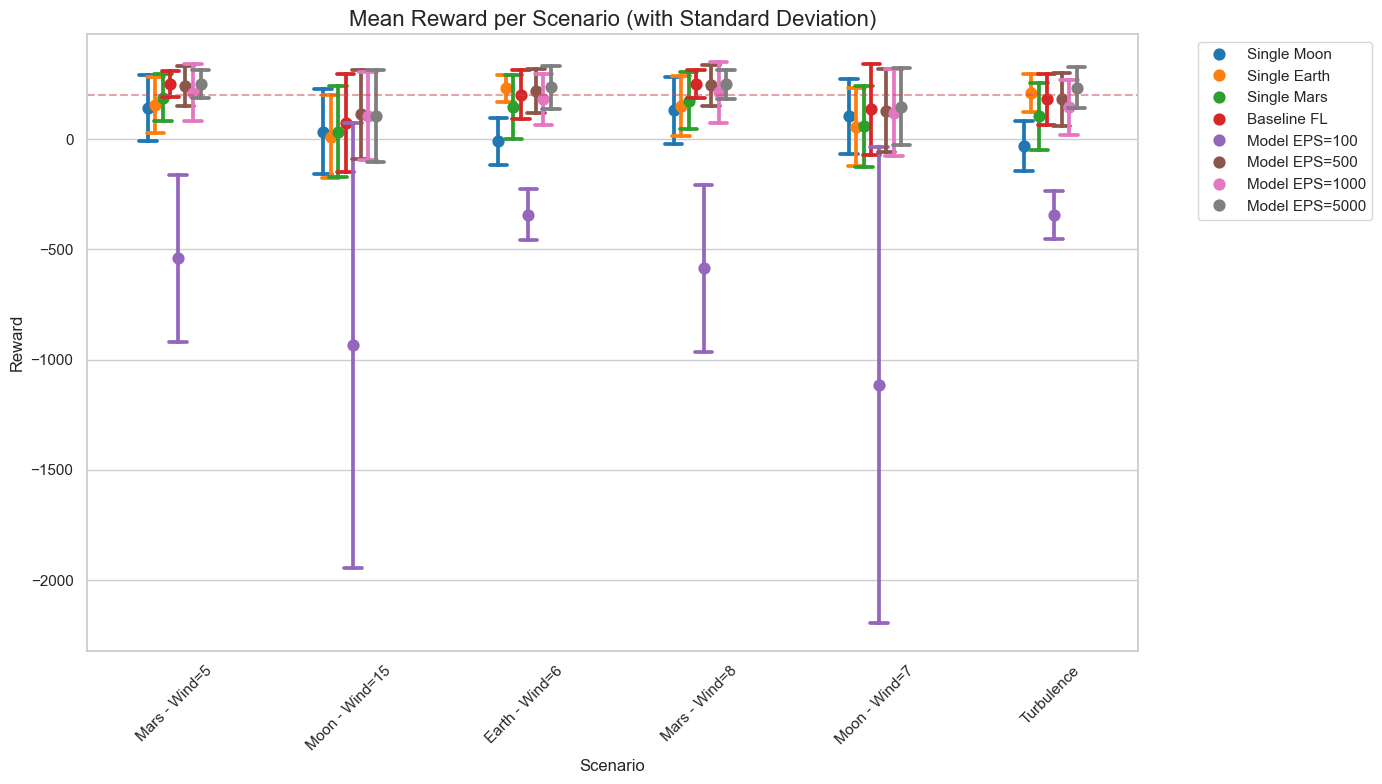

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data
df = pd.read_csv("figures/raw_episode_results.csv")
df = df[df['Scenario'] != 'Earth - No Wind']
# Set theme
sns.set_theme(style="whitegrid")

# Create a Faceted Box Plot
# We use 'col' to separate Scenarios, and 'y' for Models to make labels readable.
g = sns.catplot(
    data=df, 
    x="Reward", 
    y="Model", 
    col="Scenario", 
    kind="box", 
    col_wrap=2,        # 3 plots per row
    height=4,          # Height of each subplot
    aspect=1.5,        # Width aspect ratio
    sharex=False,      # Let x-axis (Reward) vary per scenario if ranges differ wildly
    palette="viridis", # Nice color scheme
    hue="Model",       # Assign hue to Model for palette application
    legend=False       # Hide legend since Y-axis labels serve as legend
)

# Add a vertical line for the solving threshold of LunarLander (usually 200)
# We need to iterate through axes to add the line
for ax in g.axes.flat:
    ax.axvline(x=200, color='r', linestyle='--', alpha=0.5, linewidth=1)
    ax.set_xlabel("Total Reward")

plt.savefig("figures/catplot.pdf")
# Add a title
g.fig.suptitle("RL Model Performance Distributions across Scenarios (Threshold=200)", y=1.02, fontsize=16)

# Save the figure

# Create a second plot: Aggregated Point Plot (Mean + CI)
# This is useful for a cleaner "leaderboard" style view
plt.figure(figsize=(14, 8))
sns.pointplot(
    data=df, 
    x="Scenario", 
    y="Reward", 
    hue="Model", 
    dodge=0.3,       # Separate points slightly
    join=False,      # Don't connect lines across scenarios
    palette="tab10",
    errorbar="sd",   # Show Standard Deviation instead of CI for robustness
    capsize=0.1
)
plt.title("Mean Reward per Scenario (with Standard Deviation)", fontsize=16)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(y=200, color='r', linestyle='--', alpha=0.5, label="Solved (200)")
plt.tight_layout()


## KNN Classification Of Silo

In [92]:
def extract_planet(label):
    # Format is Client_ID_Planet
    # e.g., Client_0_Earth, Client_-1_Earth
    parts = label.split('_')
    if len(parts) >= 3:
        return parts[-1]
    return "Unknown"

def knn_classifier(base_dir,experiment_name):
    print(f"Loading data from {base_dir}...")
    # Load all data
    data = load_data_recursively(base_dir)
    
    weights = data['weights']
    raw_labels = data['weight_labels']
    steps = data['weight_steps']
    
    if len(weights) == 0:
        print("No data found. Exiting.")
        return

    print(f"Total samples: {len(weights)}")
    
    # Extract labels (planet types)
    planet_labels = [extract_planet(l) for l in raw_labels]
    planet_labels = np.array(planet_labels)
    
    print(f"extracted labels: {np.unique(planet_labels, return_counts=True)}")

    # Create a DataFrame for easier handling
    df = pd.DataFrame({
        'Planet': planet_labels,
        'Step': steps
    })
    
    # Filter out Unknown if any
    mask = df['Planet'] != 'Unknown'
    X = weights[mask]
    y = planet_labels[mask]
    steps = steps[mask]
    
    # print(f"Samples after filtering unknown: {len(X)}")
    
    # Split data into train and test
    # We can do a random split, or split by round if we want to predict future rounds
    # For now, let's do a random shuffle split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # print(f"Training set size: {len(X_train)}")
    # print(f"Test set size: {len(X_test)}")
    
    # Initialize KNN
    k = 7
    knn = KNeighborsClassifier(n_neighbors=k)
    
    print(f"Training KNN with k={k}...")
    knn.fit(X_train, y_train)
    
    # print("Predicting...")
    y_pred = knn.predict(X_test)
    
    # Evaluation
    # print("\nClassification Report:")
    # print(classification_report(y_test, y_pred))
    
    # print("Confusion Matrix:")
    # cm = confusion_matrix(y_test, y_pred)
    # print(cm)
    
    acc = accuracy_score(y_test, y_pred)
    # print(f"\nAccuracy: {acc:.4f}")
    
    # Optional: Plot confusion matrix
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.title(f'KNN Confusion Matrix (k={k}, Accuracy={acc:.2f})')
    # plt.savefig(f'figures/knn_confusion_matrix_{experiment_name}.pdf')
    # plt.close()
    return acc

In [94]:
results =[]

dp_500_ACC = knn_classifier("sv_results/v5/logs/dp_fl_sens18.0_eps500.0/weights","dp_500")

results.append(["DP_500",dp_500_ACC])
dp_5000_ACC = knn_classifier("sv_results/v5/logs/dp_fl_sens18.0_eps5000/weights","dp_5000")
results.append(["DP_5000",dp_5000_ACC])
dp_100_ACC = knn_classifier("sv_results/v5/logs/dp_fl_sens18.0_eps100.0/weights","dp_100")
dp_1000_ACC = knn_classifier("sv_results/v5/logs/dp_fl_sens18.0_eps1000.0/weights","dp_1000")
results.append(["DP_100",dp_100_ACC])
# results.append(["DP_1000",dp_1000_ACC])
fl_ACC = knn_classifier("sv_results/v5/logs/fl_run/weights","fl")
results.append(["FL",fl_ACC])

acc_df = pd.DataFrame(results, columns=["Experiment", "Accuracy"])
acc_df.to_csv("figures/knn_acc.csv", index=False)
print(acc_df)


Loading data from sv_results/v5/logs/dp_fl_sens18.0_eps500.0/weights...
Scanning sv_results/v5/logs/dp_fl_sens18.0_eps500.0/weights...
Loaded 1375 weight vectors.
Total samples: 1375
extracted labels: (array(['Earth', 'Mars', 'Moon', 'Unknown'], dtype='<U7'), array([418, 431, 401, 125]))
Training KNN with k=7...
Loading data from sv_results/v5/logs/dp_fl_sens18.0_eps5000/weights...
Scanning sv_results/v5/logs/dp_fl_sens18.0_eps5000/weights...
Loaded 1375 weight vectors.
Total samples: 1375
extracted labels: (array(['Earth', 'Mars', 'Moon', 'Unknown'], dtype='<U7'), array([415, 439, 396, 125]))
Training KNN with k=7...
Loading data from sv_results/v5/logs/dp_fl_sens18.0_eps100.0/weights...
Scanning sv_results/v5/logs/dp_fl_sens18.0_eps100.0/weights...
Loaded 1375 weight vectors.
Total samples: 1375
extracted labels: (array(['Earth', 'Mars', 'Moon', 'Unknown'], dtype='<U7'), array([424, 423, 403, 125]))
Training KNN with k=7...
Loading data from sv_results/v5/logs/dp_fl_sens18.0_eps1000.